## Simulating Multi-Level Mitochondrial Data
### Objective
This notebook simulates a realistic, multi-level dataset to serve as a ground truth for validating our hierarchical Bayesian model. It generates known mitochondrial cluster signatures, a cell lineage tree, the true proportions of clusters within each cell, and the resulting "observed" VAF data.

The final output is saved to simulated_data.npz.

In [8]:
### Cell 1: Imports and Configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

### Cell 1: Imports and Configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# --- Simulation Configuration ---
# --- Simulation Configuration ---
N_CLUSTERS = 20 # mitocondrial clusters
N_LOCATIONS = 16500 #available locations across the mitochondrial genome
N_CLONES = 15 # The total number of cell clones to simulate
N_GENERATIONS = 3 # The number of evolutionary steps for clone generation
MIN_CELLS_PER_CLONE = 50
MAX_CELLS_PER_CLONE = 200
MIN_VARIANTS_PER_CLUSTER = 3
MAX_VARIANTS_PER_CLUSTER = 50

In [9]:
### Cell 2: Data Generation Function for Clones and Cells

def generate_simulated_data(n_clusters, n_locations, n_clones, n_generations, 
                            min_cells_pc, max_cells_pc, min_variants, max_variants):
    """
    Generates a complete set of simulated data with a lineage of cell clones,
    and individual cells within each clone. Assumes binary VAFs (0 or 1) in signatures.
    """
    
    # 1. Define Ground Truth Cluster Signatures (K_true)
    print("1. Generating known mitochondrial cluster signatures (K_true)...")
    K_true = np.zeros((n_locations, n_clusters))
    for i in range(n_clusters):
        num_variants = np.random.randint(min_variants, max_variants + 1)
        mut_sites = np.random.choice(n_locations, num_variants, replace=False)
        
        # MODIFIED: VAFs for signature variants are now set directly to 1.0
        K_true[mut_sites, i] = 1.0

    # 2. Simulate a Clone Lineage Tree & True Proportions for Clones
    print("2. Simulating a cell clone lineage and proportions for each clone...")
    clone_lineage_map = {} # {daughter_clone_id: mother_clone_id}
    P_clones_true = np.zeros((n_clones, n_clusters))
    
    concentration_alpha_inter_clone = 50.0 # Drift between clones

    # Create the root clone
    props = np.random.rand(n_clusters)
    root_proportions = props / props.sum()
    P_clones_true[0, :] = root_proportions
    
    clone_counter = 1
    active_clones = [0]

    for gen in range(n_generations):
        if clone_counter >= n_clones or not active_clones: break
        next_gen_active_clones = []
        clones_spawning_this_gen = np.random.choice(
            active_clones, 
            size=int(np.ceil(len(active_clones) * np.random.uniform(0.7, 1.0))), 
            replace=False
        )
        for mother_clone_id in clones_spawning_this_gen:
            num_daughter_clones = np.random.choice([1, 2, 3], p=[0.5, 0.4, 0.1])
            for _ in range(num_daughter_clones):
                if clone_counter >= n_clones: break
                mother_props = P_clones_true[mother_clone_id, :]
                mother_props_safe = np.where(mother_props == 0, 1e-6, mother_props)
                daughter_props = np.random.dirichlet(concentration_alpha_inter_clone * mother_props_safe)
                P_clones_true[clone_counter, :] = daughter_props
                clone_lineage_map[clone_counter] = mother_clone_id
                next_gen_active_clones.append(clone_counter)
                clone_counter += 1
        active_clones.extend(next_gen_active_clones)

    P_clones_true = P_clones_true[:clone_counter, :]
    n_clones_created = clone_counter

    # 3. For each clone, simulate individual cells with similar compositions
    print("3. Simulating individual cells within each clone...")
    cell_proportions_list = []
    cell_to_clone_map = {} # {cell_id: clone_id}
    cell_id_counter = 0
    concentration_alpha_intra_clone = 200.0 # Low drift within a clone

    for clone_id in range(n_clones_created):
        num_cells_in_clone = np.random.randint(min_cells_pc, max_cells_pc + 1)
        parent_clone_props = P_clones_true[clone_id, :]
        parent_clone_props_safe = np.where(parent_clone_props == 0, 1e-6, parent_clone_props)
        
        for _ in range(num_cells_in_clone):
            # Draw cell proportions from a tight distribution around the parent clone's props
            cell_props = np.random.dirichlet(concentration_alpha_intra_clone * parent_clone_props_safe)
            cell_proportions_list.append(cell_props)
            cell_to_clone_map[cell_id_counter] = clone_id
            cell_id_counter += 1
            
    P_cells_true = np.array(cell_proportions_list)

    # 4. Generate "Observed" Data based on individual cells
    print("4. Generating 'observed' VAFs for each cell with simulated noise...")
    C_true = P_cells_true @ K_true.T 

    noise_level = 0.005
    C_observed = C_true + np.random.normal(0, noise_level, size=C_true.shape)
    C_observed = np.clip(C_observed, 0, 1) 

    VAF_tissue_observed = np.mean(C_observed, axis=0)

    print("\n--- Data Simulation Complete ---")
    
    return {
        "K_true": K_true,
        "P_clones_true": P_clones_true,
        "P_cells_true": P_cells_true,
        "C_observed": C_observed,
        "VAF_tissue_observed": VAF_tissue_observed,
        "clone_lineage_map": clone_lineage_map,
        "cell_to_clone_map": cell_to_clone_map,
        "N_CLONES": n_clones_created,
        "N_CELLS": cell_id_counter,
        "N_CLUSTERS": n_clusters,
        "N_LOCATIONS": n_locations
    }

In [10]:
### Cell 3: Execute Simulation

simulated_data = generate_simulated_data(
    N_CLUSTERS, 
    N_LOCATIONS, 
    N_CLONES, 
    N_GENERATIONS, 
    MIN_CELLS_PER_CLONE,
    MAX_CELLS_PER_CLONE,
    MIN_VARIANTS_PER_CLUSTER, 
    MAX_VARIANTS_PER_CLUSTER
)

1. Generating known mitochondrial cluster signatures (K_true)...
2. Simulating a cell clone lineage and proportions for each clone...
3. Simulating individual cells within each clone...
4. Generating 'observed' VAFs for each cell with simulated noise...

--- Data Simulation Complete ---


In [11]:
### Cell 4: Inspect the Structure of the Simulated Data

print("\n--- Inspecting Simulated Data Structure ---")

n_clones_created = simulated_data["N_CLONES"]
n_cells_created = simulated_data["N_CELLS"]
p_cells_shape = simulated_data["P_cells_true"].shape
c_observed_shape = simulated_data["C_observed"].shape
clone_lineage_size = len(simulated_data["clone_lineage_map"])

print(f"Total number of clones created: {n_clones_created}")
print(f"Total number of cells created: {n_cells_created}")
print(f"Shape of True Cell Proportions matrix (P_cells_true): {p_cells_shape}")
print(f"Shape of Observed Cell VAF matrix (C_observed): {c_observed_shape}")
print(f"Number of parent-daughter relationships in clone lineage: {clone_lineage_size}")

if n_clones_created <= 1:
    print("\nWARNING: The simulation only produced 1 clone. The lineage did not grow.")
else:
    print("\nSimulation produced a multi-clone lineage. Proceeding with visualization.")


--- Inspecting Simulated Data Structure ---
Total number of clones created: 10
Total number of cells created: 1105
Shape of True Cell Proportions matrix (P_cells_true): (1105, 20)
Shape of Observed Cell VAF matrix (C_observed): (1105, 16500)
Number of parent-daughter relationships in clone lineage: 9

Simulation produced a multi-clone lineage. Proceeding with visualization.



--- Visualizing Ground Truth Data ---


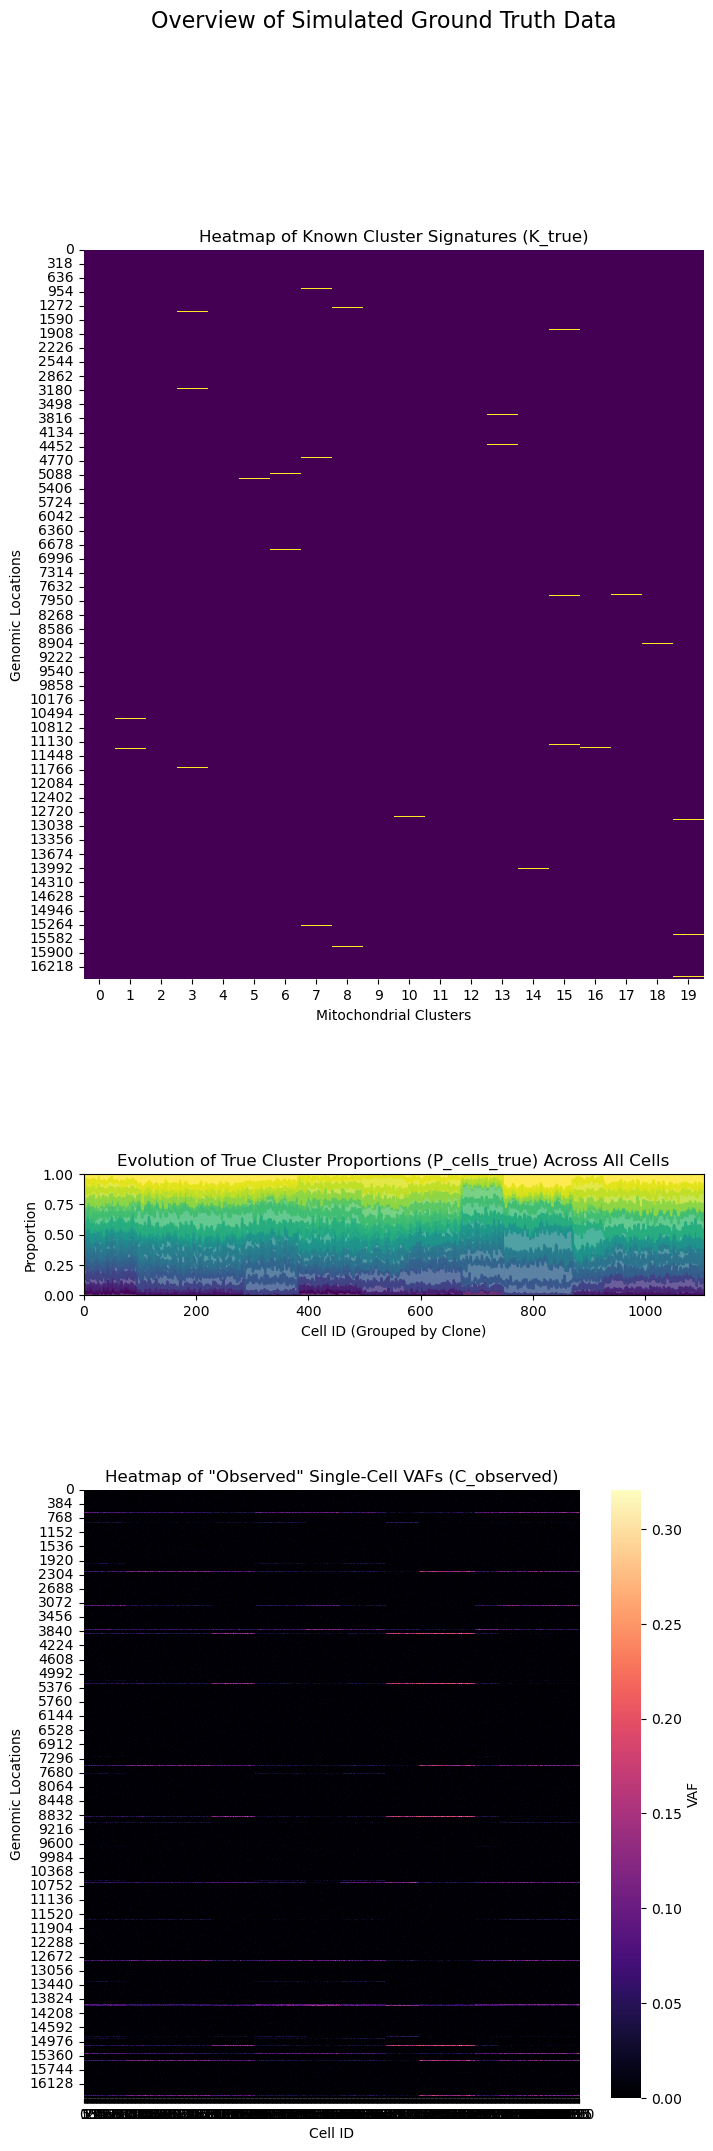

In [12]:
### Cell 5: Visualization of Simulated Data

print("\n--- Visualizing Ground Truth Data ---")

K_true = simulated_data["K_true"]
P_cells_true = simulated_data["P_cells_true"]
C_observed = simulated_data["C_observed"]
N_CLUSTERS_VIZ = simulated_data["N_CLUSTERS"]
N_CELLS_VIZ = simulated_data["N_CELLS"]

cell_ids = np.arange(N_CELLS_VIZ)

fig, axes = plt.subplots(3, 1, figsize=(8, 24), gridspec_kw={'height_ratios': [6, 1, 5]})
fig.suptitle('Overview of Simulated Ground Truth Data', fontsize=16)
plt.subplots_adjust(hspace=0.4)

# 1. Visualize the Cluster Signatures (K_true)
sns.heatmap(K_true, ax=axes[0], cmap="viridis", cbar=False)
axes[0].set_title('Heatmap of Known Cluster Signatures (K_true)')
axes[0].set_xlabel('Mitochondrial Clusters')
axes[0].set_ylabel('Genomic Locations')

# 2. Visualize the True Proportions for each CELL (P_cells_true)
p_df = pd.DataFrame(P_cells_true, columns=[f'Cluster {i+1}' for i in range(N_CLUSTERS_VIZ)], index=cell_ids)
p_df.plot(kind='area', stacked=True, ax=axes[1], colormap='viridis', alpha=0.8, legend=False)
axes[1].set_title('Evolution of True Cluster Proportions (P_cells_true) Across All Cells')
axes[1].set_xlabel('Cell ID (Grouped by Clone)')
axes[1].set_ylabel('Proportion')
axes[1].set_ylim(0, 1)
axes[1].set_xlim(0, max(1, N_CELLS_VIZ - 1))

# 3. Visualize the Observed Cell VAFs (C_observed)
tick_frequency = 5
xticklabels = [i if i % tick_frequency == 0 else '' for i in cell_ids]
sns.heatmap(C_observed.T, ax=axes[2], cmap="magma", cbar=True, cbar_kws={'label': 'VAF'}, xticklabels=xticklabels)
axes[2].set_title('Heatmap of "Observed" Single-Cell VAFs (C_observed)')
axes[2].set_xlabel('Cell ID')
axes[2].set_ylabel('Genomic Locations')
axes[2].tick_params(axis='x', rotation=0)

plt.show()


--- Visualizing the Simulated Clone Lineage ---


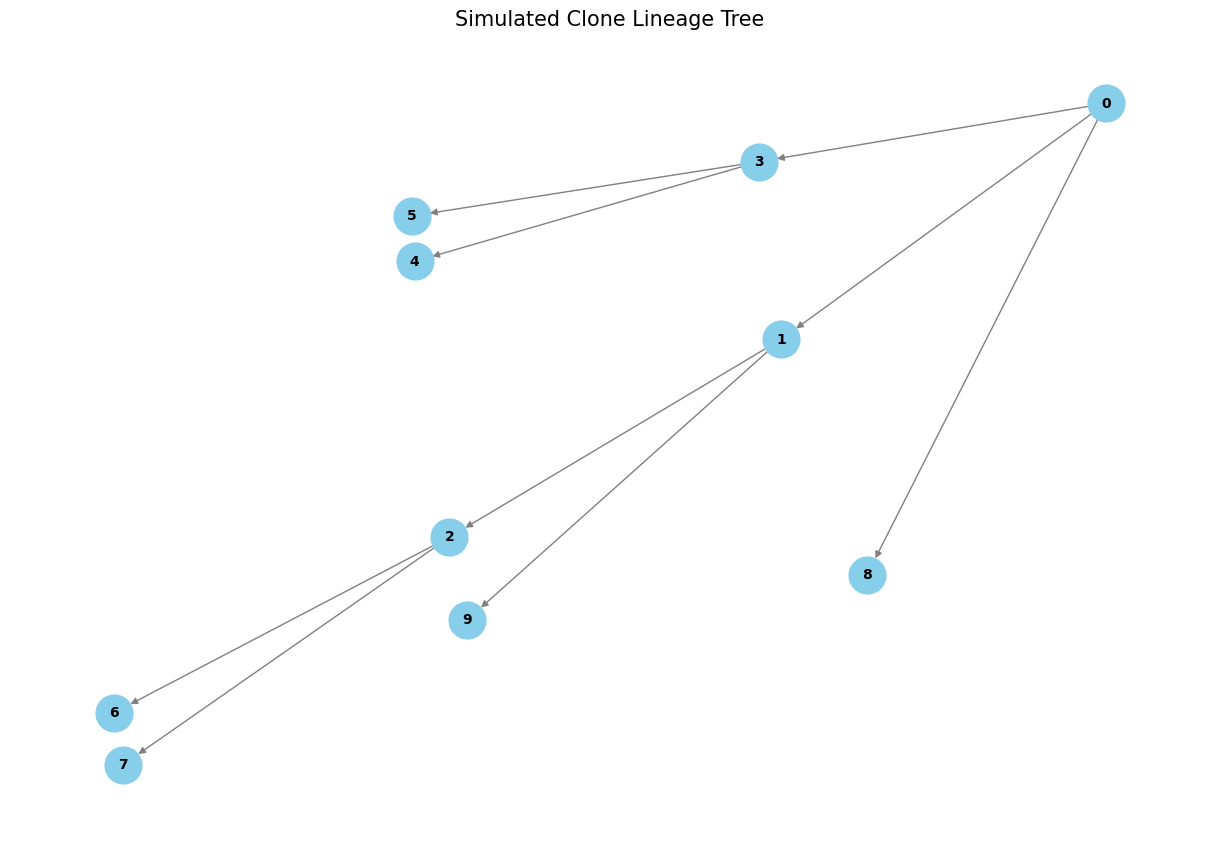

In [13]:
### Cell 6: Visualize the Simulated Clone Lineage Tree

print("\n--- Visualizing the Simulated Clone Lineage ---")

clone_lineage_map = simulated_data['clone_lineage_map']

G = nx.DiGraph()
G.add_node(0)
for daughter, mother in clone_lineage_map.items():
    G.add_edge(mother, daughter)

pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700,
        edge_color='gray', font_size=10, font_weight='bold', arrows=True)
plt.title('Simulated Clone Lineage Tree', size=15)
plt.show()

In [15]:
### Cell 7: Save Simulated Data to File

output_filename = '../sim_data/simulated_data_06.npz'
np.savez_compressed(output_filename, **simulated_data)
print(f"\nSimulated data successfully saved to '{output_filename}'")



Simulated data successfully saved to '../sim_data/simulated_data_06.npz'
